# Spain Local Train Transportation: Predict Fair Paid  

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [203]:
df = pd.read_csv('Spain Rail Transportation.csv')
df

,Unnamed: 0,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
0,0.0,4/19/2019 5:31,MADRID,SEVILLA,5/29/2019 6:20,5/29/2019 9:16,AV City,38.55,Turista,Promo
1,1.0,4/19/2019 5:31,MADRID,SEVILLA,5/29/2019 7:00,5/29/2019 9:32,AVE,53.40,Turista,Promo
2,2.0,4/19/2019 5:31,MADRID,SEVILLA,5/29/2019 7:30,5/29/2019 9:51,AVE,47.30,Turista,Promo
3,3.0,4/19/2019 5:31,MADRID,SEVILLA,5/29/2019 8:00,5/29/2019 10:32,AVE,69.40,Preferente,Promo
4,4.0,4/19/2019 5:31,MADRID,SEVILLA,5/29/2019 8:30,5/29/2019 11:14,ALVIA,NaN,Turista,Promo
...,...,...,...,...,...,...,...,...,...,...
1048570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 	Create a statistical summary of the data set

In [204]:
df.describe(include='O').transpose()

,count,unique,top,freq
insert_date,30000,257,4/19/2019 7:02,307
origin,30000,5,MADRID,14850
destination,30000,5,MADRID,15150
start_date,30000,4520,4/28/2019 17:30,28
end_date,30000,5872,6/2/2019 23:03,18
train_type,30000,15,AVE,20464
train_class,29835,6,Turista,22509
fare,29835,5,Promo,19878


In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 10 columns):
Unnamed: 0     30000 non-null float64
insert_date    30000 non-null object
origin         30000 non-null object
destination    30000 non-null object
start_date     30000 non-null object
end_date       30000 non-null object
train_type     30000 non-null object
price          27830 non-null float64
train_class    29835 non-null object
fare           29835 non-null object
dtypes: float64(2), object(8)
memory usage: 80.0+ MB


In [206]:
df['price'].fillna(df['price'].mean(),inplace=True)

In [207]:
transp_df = df.dropna()

In [208]:
transp_df.isnull().sum()

Unnamed: 0     0
insert_date    0
origin         0
destination    0
start_date     0
end_date       0
train_type     0
price          0
train_class    0
fare           0
dtype: int64

In [209]:
transp_df.drop('insert_date',axis=1,inplace=True)

In [210]:
transp_df.describe()

,Unnamed: 0,price
count,29835.000000,29835.000000
mean,15003.622155,62.416162
std,8658.537215,24.964809
min,0.000000,16.600000
25%,7508.500000,45.300000
50%,15000.000000,62.200000
75%,22508.500000,76.300000
max,29999.000000,214.200000


In [211]:
transp_df.shape

(29835, 9)

In [212]:
import datetime
datetimeFormat = '%m/%d/%Y %H:%M'
transp_df['start_date'] = transp_df.apply(lambda x:datetime.datetime.strptime(x['start_date'], datetimeFormat),axis=1) 
transp_df['end_date'] = transp_df.apply(lambda x:datetime.datetime.strptime(x['end_date'], datetimeFormat),axis=1)

In [213]:
transp_df['travel_time(hrs)'] = transp_df.apply(lambda x:(x['end_date']-x['start_date']).seconds/3600,axis=1)

In [214]:
transp_df.head()

,Unnamed: 0,origin,destination,start_date,end_date,train_type,price,train_class,fare,travel_time(hrs)
0,0.0,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.550000,Turista,Promo,2.933333
1,1.0,MADRID,SEVILLA,2019-05-29 07:00:00,2019-05-29 09:32:00,AVE,53.400000,Turista,Promo,2.533333
2,2.0,MADRID,SEVILLA,2019-05-29 07:30:00,2019-05-29 09:51:00,AVE,47.300000,Turista,Promo,2.350000
3,3.0,MADRID,SEVILLA,2019-05-29 08:00:00,2019-05-29 10:32:00,AVE,69.400000,Preferente,Promo,2.533333
4,4.0,MADRID,SEVILLA,2019-05-29 08:30:00,2019-05-29 11:14:00,ALVIA,62.416162,Turista,Promo,2.733333


In [215]:
transp_df = transp_df.reset_index()

## Create a plot to show what is the average time between ORIGIN and DESTINATION

Text(0.5, 0, 'Travel Time (hrs)')

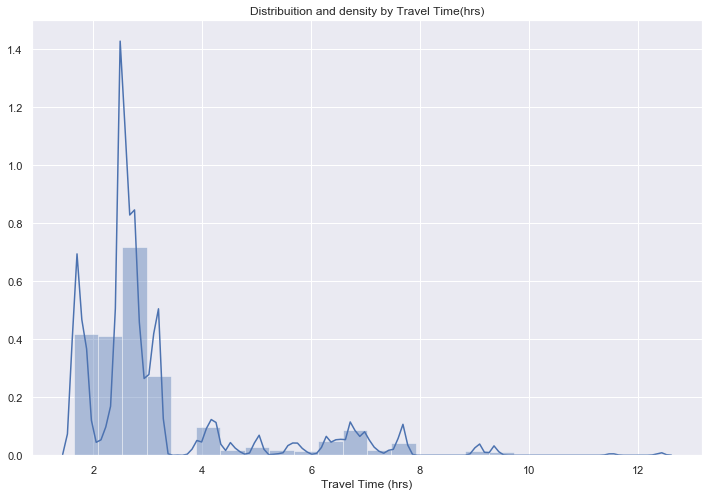

In [216]:
plt.figure(figsize=(12,8))
sns.distplot(transp_df['travel_time(hrs)'], bins=24)
plt.title("Distribuition and density by Travel Time(hrs)")
plt.xlabel("Travel Time (hrs)")

## 	Group all the data per month, per week. Make a plot to display:

In [217]:
transp_df['Week_Number'] = transp_df['start_date'].dt.week
transp_df['Month'] = transp_df['start_date'].dt.month

In [218]:
transp_df.head()

,index,Unnamed: 0,origin,destination,start_date,end_date,train_type,price,train_class,fare,travel_time(hrs),Week_Number,Month
0,0,0.0,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.550000,Turista,Promo,2.933333,22,5
1,1,1.0,MADRID,SEVILLA,2019-05-29 07:00:00,2019-05-29 09:32:00,AVE,53.400000,Turista,Promo,2.533333,22,5
2,2,2.0,MADRID,SEVILLA,2019-05-29 07:30:00,2019-05-29 09:51:00,AVE,47.300000,Turista,Promo,2.350000,22,5
3,3,3.0,MADRID,SEVILLA,2019-05-29 08:00:00,2019-05-29 10:32:00,AVE,69.400000,Preferente,Promo,2.533333,22,5
4,4,4.0,MADRID,SEVILLA,2019-05-29 08:30:00,2019-05-29 11:14:00,ALVIA,62.416162,Turista,Promo,2.733333,22,5


## a.	The Number of tickets bought

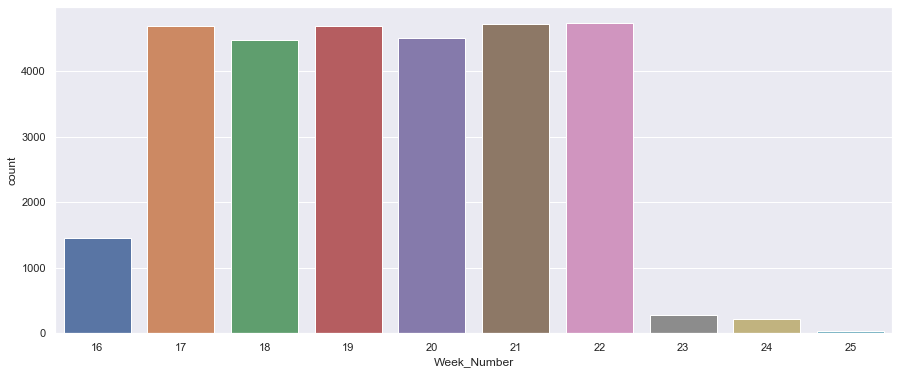

In [219]:
fig,ax = plt.subplots(figsize=(15,6))
ax = sns.countplot(transp_df['Week_Number'])
plt.show()

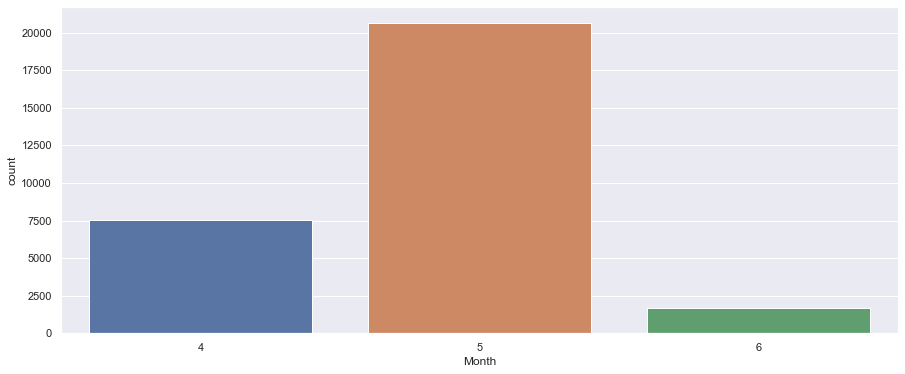

In [220]:
fig,ax = plt.subplots(figsize=(15,6))
ax = sns.countplot(transp_df['Month'])
plt.show()

## b.	The Trend of the average travel time 

Text(0, 0.5, 'Average Travel Time in hrs')

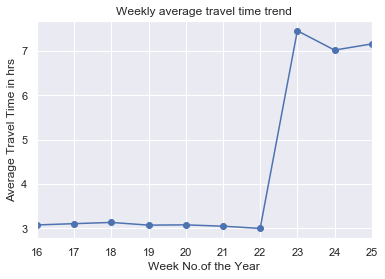

In [221]:
ax = transp_df.groupby(['Week_Number'])['travel_time(hrs)'].mean().plot(kind='line', marker = 'o', title = 'Weekly average travel time trend')
ax.set_xlabel('Week No.of the Year')
ax.set_ylabel('Average Travel Time in hrs')

Text(0, 0.5, 'Average Travel Time in hrs')

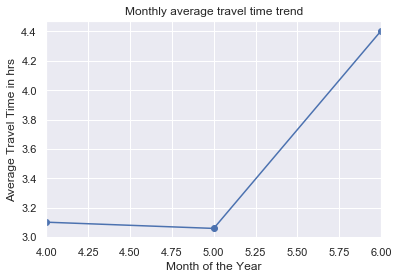

In [222]:
ax = transp_df.groupby(['Month'])['travel_time(hrs)'].mean().plot(kind='line', marker = 'o', title = 'Monthly average travel time trend')
ax.set_xlabel('Month of the Year')
ax.set_ylabel('Average Travel Time in hrs')

## c.	The Trend of the price

Text(0, 0.5, 'Average ticket price')

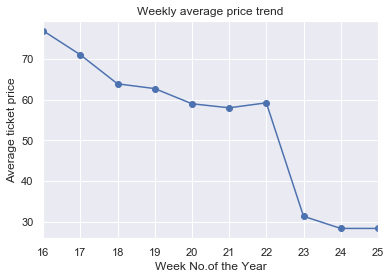

In [223]:
ax = transp_df.groupby(['Week_Number'])['price'].mean().plot(kind='line', marker = 'o', title = 'Weekly average price trend')
ax.set_xlabel('Week No.of the Year')
ax.set_ylabel('Average ticket price')

Text(0, 0.5, 'Average ticket price')

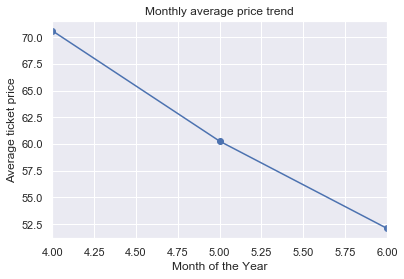

In [224]:
ax = transp_df.groupby(['Month'])['price'].mean().plot(kind='line', marker = 'o', title = 'Monthly average price trend')
ax.set_xlabel('Month of the Year')
ax.set_ylabel('Average ticket price')

## d.	A bar plot to see the distribution of destination, train type, train class, and fare.

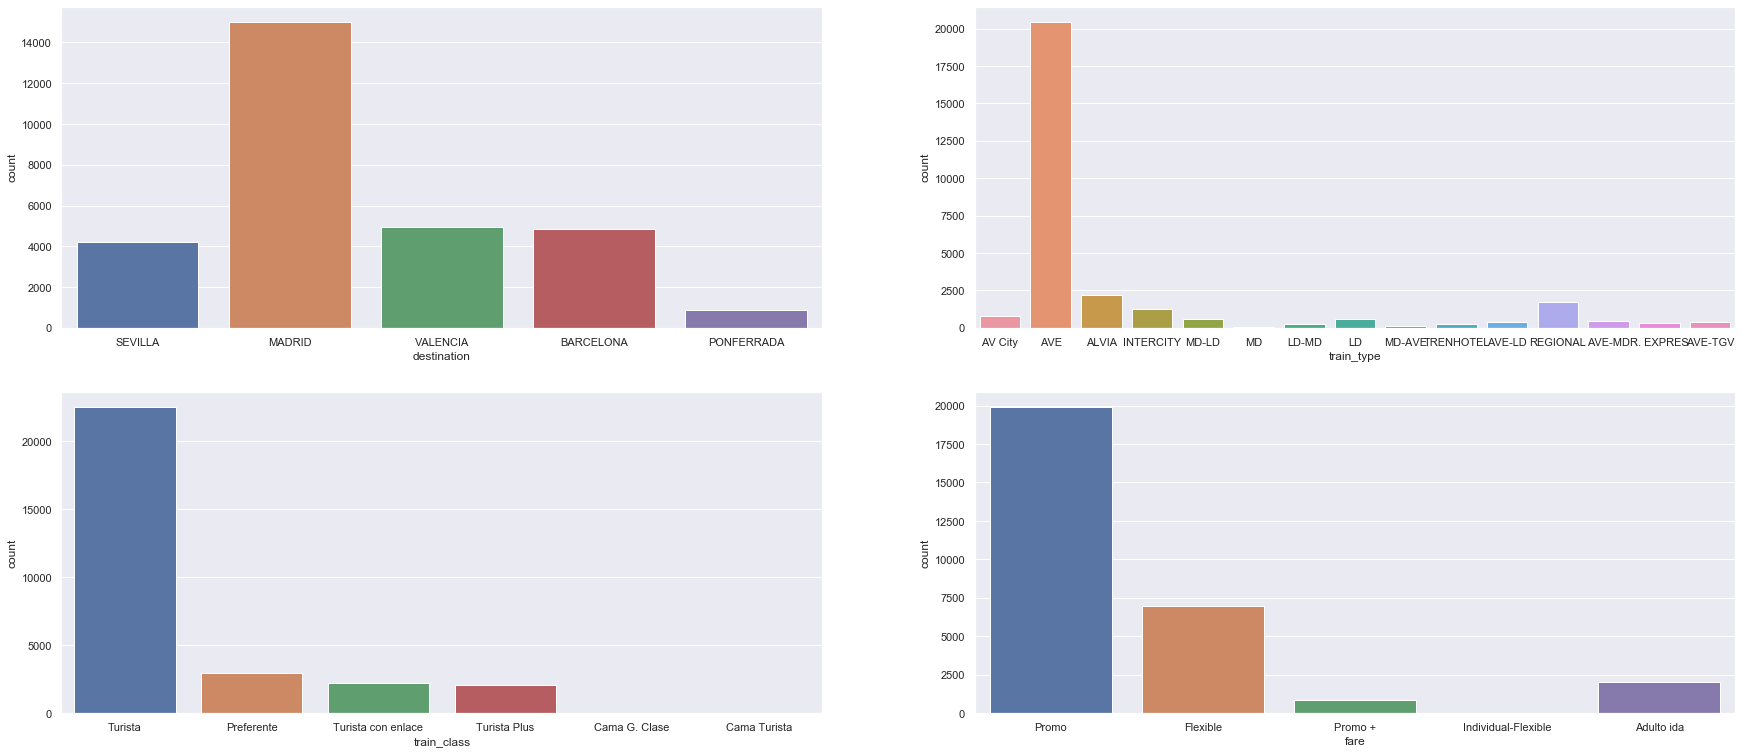

In [225]:
fig, ax = plt.subplots(figsize = (30,13), nrows=2,ncols =2)
sns.countplot(transp_df['destination'], ax=ax[0,0])
sns.countplot(transp_df['train_type'], ax=ax[0,1])
sns.countplot(transp_df['train_class'],ax=ax[1,0])
sns.countplot(transp_df['fare'],ax=ax[1,1])
plt.show()

In [226]:
transp_df.drop(['Unnamed: 0','start_date','end_date', 'index'],axis=1,inplace=True)
transp_df.head()

,origin,destination,train_type,price,train_class,fare,travel_time(hrs),Week_Number,Month
0,MADRID,SEVILLA,AV City,38.550000,Turista,Promo,2.933333,22,5
1,MADRID,SEVILLA,AVE,53.400000,Turista,Promo,2.533333,22,5
2,MADRID,SEVILLA,AVE,47.300000,Turista,Promo,2.350000,22,5
3,MADRID,SEVILLA,AVE,69.400000,Preferente,Promo,2.533333,22,5
4,MADRID,SEVILLA,ALVIA,62.416162,Turista,Promo,2.733333,22,5


Text(0.5, 0, 'Price')

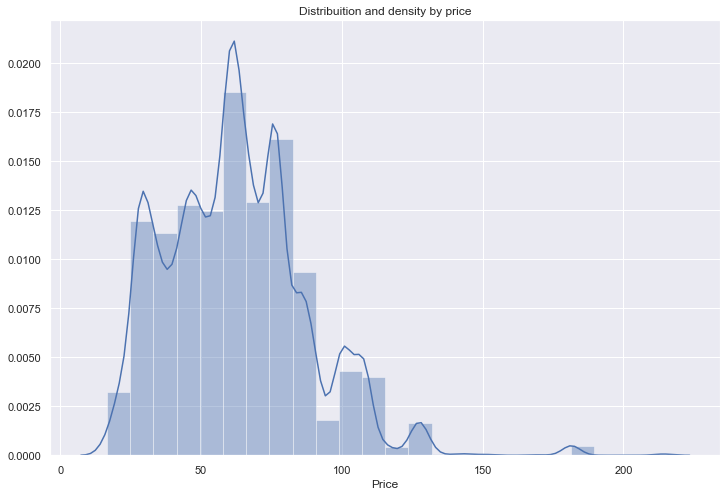

In [227]:
plt.figure(figsize=(12,8))
sns.distplot(transp_df['price'], bins=24)
plt.title("Distribuition and density by price")
plt.xlabel("Price")

In [228]:
# Stratifying the price data

transp_df['price'] = pd.cut(transp_df['price'], bins=[0,20,40,60,80,100,np.inf], labels=[1,2,3,4,5,6])

Text(0, 0.5, 'Number of tickets')

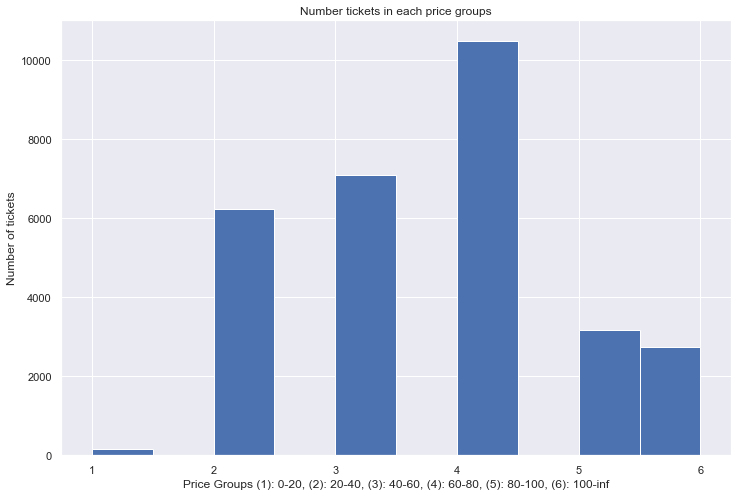

In [229]:
plt.figure(figsize=(12,8))
transp_df['price'].hist()
plt.title('Number tickets in each price groups')
plt.xlabel('Price Groups (1): 0-20, (2): 20-40, (3): 40-60, (4): 60-80, (5): 80-100, (6): 100-inf')
plt.ylabel('Number of tickets')

In [230]:
# Stratifying the travel time data

transp_df['travel_time(hrs)'] = pd.cut(transp_df['travel_time(hrs)'], bins=[0,2,2.5,3,3.5,np.inf], labels=[1,2,3,4,5])

Text(0, 0.5, 'Number of tickets')

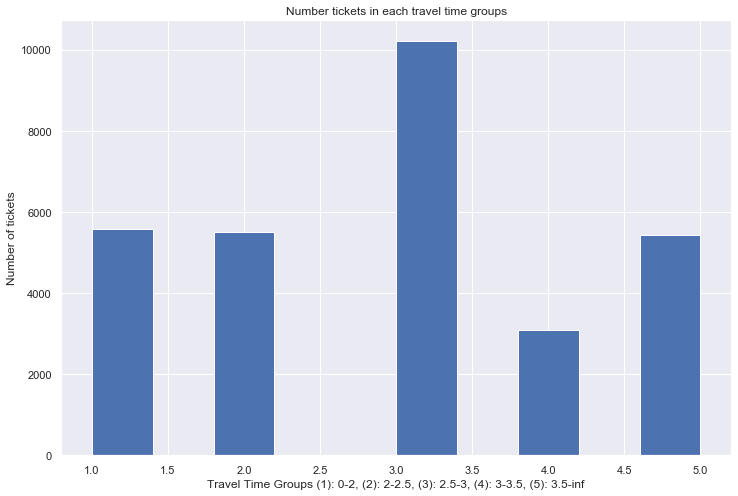

In [231]:
plt.figure(figsize=(12,8))
transp_df['travel_time(hrs)'].hist()
plt.title('Number tickets in each travel time groups')
plt.xlabel('Travel Time Groups (1): 0-2, (2): 2-2.5, (3): 2.5-3, (4): 3-3.5, (5): 3.5-inf')
plt.ylabel('Number of tickets')

In [232]:
transp_df.head()

,origin,destination,train_type,price,train_class,fare,travel_time(hrs),Week_Number,Month
0,MADRID,SEVILLA,AV City,2,Turista,Promo,3,22,5
1,MADRID,SEVILLA,AVE,3,Turista,Promo,3,22,5
2,MADRID,SEVILLA,AVE,3,Turista,Promo,2,22,5
3,MADRID,SEVILLA,AVE,4,Preferente,Promo,3,22,5
4,MADRID,SEVILLA,ALVIA,4,Turista,Promo,3,22,5


In [233]:
"""Chi-Square test to perform hypothesis testing, if a categorical feature has relationship with 
the categorical output to be predicted"""

class ChiSquare:
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        
        self.dfObserved = None
        self.dfExpected = None
        
    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT for Prediction".format(colX) 
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)
        print(result)
        
    def TestIndependence(self,colX,colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        
        self._print_chisquare_result(colX,alpha)
        
        print('p_value: %.8f, \n' % p)
        
        return p

In [234]:
#Initialize ChiSquare Class
cT = ChiSquare(transp_df)

#Feature Selection
testColumns = list(transp_df.columns)
testColumns.remove('fare')

p_values = []

for var in testColumns:
    p_values.append(cT.TestIndependence(colX=var,colY="fare"))
    
chi2_results =pd.DataFrame(list(zip(testColumns,p_values)), columns = ['Feature', 'P-value'])    

origin is IMPORTANT for Prediction
p_value: 0.00000000, 

destination is IMPORTANT for Prediction
p_value: 0.00000000, 

train_type is IMPORTANT for Prediction
p_value: 0.00000000, 

price is IMPORTANT for Prediction
p_value: 0.00000000, 

train_class is IMPORTANT for Prediction
p_value: 0.00000000, 

travel_time(hrs) is IMPORTANT for Prediction
p_value: 0.00000000, 

Week_Number is IMPORTANT for Prediction
p_value: 0.00000000, 

Month is IMPORTANT for Prediction
p_value: 0.00000000, 



In [235]:
transp_df_1 = transp_df.pop('fare') # remove column b and store it in df1
transp_df['fare']=transp_df_1
transp_df.head()

,origin,destination,train_type,price,train_class,travel_time(hrs),Week_Number,Month,fare
0,MADRID,SEVILLA,AV City,2,Turista,3,22,5,Promo
1,MADRID,SEVILLA,AVE,3,Turista,3,22,5,Promo
2,MADRID,SEVILLA,AVE,3,Turista,2,22,5,Promo
3,MADRID,SEVILLA,AVE,4,Preferente,3,22,5,Promo
4,MADRID,SEVILLA,ALVIA,4,Turista,3,22,5,Promo


In [236]:
le = LabelEncoder()
transp_df['fare'] = le.fit_transform(transp_df['fare']) 

In [237]:
le.classes_

array(['Adulto ida', 'Flexible', 'Individual-Flexible', 'Promo',
       'Promo +'], dtype=object)

In [238]:
# Stratified sampling to ensure each train class is represented in our training and testing datasets

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state=42)
for train_index, test_index in split.split(transp_df, transp_df['train_class']):
    strat_train_set = transp_df.loc[train_index]
    strat_test_set = transp_df.loc[test_index]
    
strat_test_set['train_class'].value_counts() / len(strat_test_set)

Turista               0.754483
Preferente            0.100553
Turista con enlace    0.075415
Turista Plus          0.069046
Cama Turista          0.000335
Cama G. Clase         0.000168
Name: train_class, dtype: float64

In [239]:
strat_train_set.head()

,origin,destination,train_type,price,train_class,travel_time(hrs),Week_Number,Month,fare
21368,PONFERRADA,MADRID,TRENHOTEL,3,Turista,5,17,4,1
484,SEVILLA,MADRID,AVE,4,Preferente,2,19,5,3
4150,SEVILLA,MADRID,AVE,4,Turista,3,16,4,1
13079,MADRID,SEVILLA,AVE,4,Turista,2,17,4,1
18410,MADRID,BARCELONA,AVE,5,Turista Plus,2,18,5,3


In [240]:
cat_encoder = OneHotEncoder()
X_train =  cat_encoder.fit_transform(strat_train_set.drop('fare', axis = 1))

In [241]:
y_train = strat_train_set['fare'].copy()

In [242]:
cat_encoder = OneHotEncoder()
X_test =  cat_encoder.fit_transform(strat_test_set.drop('fare', axis = 1))

In [243]:
y_test = strat_test_set['fare'].copy()

## Evaluate and compare SVM, DT, and RF, to determine what fare will paid, based on the feature you consider relevant. 
## Which one of these three methods gives the best result? 
## What are the best parameters for each algorithm?

## Model 1: Support Vector Classification (SVC)

In [244]:
from sklearn.svm import SVC 

param_grid_svm = {'C': [0.1, 1, 10],  
              'gamma': [1, 0.1, 0.01], 'kernel': ['linear']}

svm_Linear = SVC()

grid_search_svm = GridSearchCV(svm_Linear , param_grid = param_grid_svm, cv=2, scoring = 'accuracy',return_train_score=True)

grid_search_svm.fit(X_train, y_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [245]:
print(grid_search_svm.best_params_)

{'C': 10, 'gamma': 1, 'kernel': 'linear'}


In [246]:
print(grid_search_svm.best_estimator_)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [247]:
print('Best training accuracy score for SVC is: ', grid_search_svm.cv_results_['mean_train_score'][grid_search_svm.best_index_])

Best training accuracy score for SVC is:  0.8975613738640098


In [248]:
y_predict_svm = grid_search_svm.predict(X_test)

In [249]:
print('Predictions:', le.inverse_transform(y_predict_svm[:5]))

Predictions: ['Flexible' 'Flexible' 'Adulto ida' 'Flexible' 'Promo']


In [250]:
print('Labels:', le.inverse_transform(y_test.iloc[:5]))

Labels: ['Promo' 'Flexible' 'Adulto ida' 'Flexible' 'Promo']


In [251]:
cm_svm = confusion_matrix(y_test,y_predict_svm)
                          
print(confusion_matrix(y_test,y_predict_svm))

[[ 403    0    0    0    0]
 [   0 1137    0  224   16]
 [   0    0    1    0    0]
 [   0  287    0 3718    5]
 [   0   51    0   10  115]]


(5.0, 0.0)

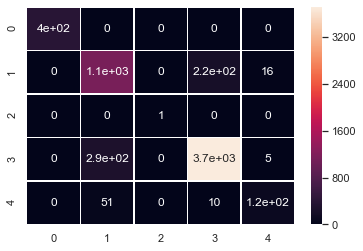

In [252]:
sns.set()
ax=sns.heatmap(cm_svm, annot=True, linewidths=.5)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [253]:
print(classification_report(y_test,y_predict_svm,target_names = ['Adulto ida', 'Flexible', 'Individual-Flexible', 'Promo',
       'Promo +']))

                     precision    recall  f1-score   support

         Adulto ida       1.00      1.00      1.00       403
           Flexible       0.77      0.83      0.80      1377
Individual-Flexible       1.00      1.00      1.00         1
              Promo       0.94      0.93      0.93      4010
            Promo +       0.85      0.65      0.74       176

           accuracy                           0.90      5967
          macro avg       0.91      0.88      0.89      5967
       weighted avg       0.90      0.90      0.90      5967



In [254]:
score_svm = round(accuracy_score(y_test, y_predict_svm, normalize=True),4)
print('Testing Accuracy Score for SVM is:', score_svm)

Testing Accuracy Score for SVM is: 0.9006


In [255]:
scores_svm = cross_val_score(grid_search_svm,X_train,y_train,scoring='accuracy',cv=5)
error_svm = [round(1-x,4) for x in scores_svm]

In [256]:
error_svm

[0.0951, 0.107, 0.1049, 0.1075, 0.1104]

## Model 2: Decision Tree

In [257]:
from sklearn.tree import DecisionTreeClassifier 

param_grid_dt = {'max_leaf_nodes': [5, 20, 30], 'min_samples_split': [2, 3, 4]}

dt = DecisionTreeClassifier(random_state= 42)

grid_search_dt = GridSearchCV(dt , param_grid = param_grid_dt, cv=2, scoring = 'accuracy',return_train_score=True)

grid_search_dt.fit(X_train, y_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_leaf_nodes': [5, 20, 30],
                         'min_samples_split': [2, 3, 4]},
             pre_dispatc

In [258]:
print(grid_search_dt.best_params_)

{'max_leaf_nodes': 30, 'min_samples_split': 2}


In [259]:
print(grid_search_dt.best_estimator_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=30,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')


In [260]:
print('Best training accuracy score for Decision Tree is: ', grid_search_dt.cv_results_['mean_train_score'][grid_search_dt.best_index_])

Best training accuracy score for Decision Tree is:  0.9071561294732062


In [261]:
y_predict_dt = grid_search_dt.predict(X_test)

In [262]:
print('Predictions:', le.inverse_transform(y_predict_dt[:5]))

Predictions: ['Flexible' 'Promo' 'Adulto ida' 'Flexible' 'Promo']


In [263]:
print('Labels:', le.inverse_transform(y_test.iloc[:5]))

Labels: ['Promo' 'Flexible' 'Adulto ida' 'Flexible' 'Promo']


In [264]:
cm_dt = confusion_matrix(y_test,y_predict_dt)

print(confusion_matrix(y_test,y_predict_dt))

[[ 403    0    0    0    0]
 [   0 1281    0   96    0]
 [   0    1    0    0    0]
 [   0  366    0 3637    7]
 [   0   66    0   16   94]]


(5.0, 0.0)

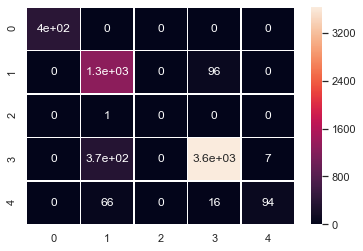

In [265]:
sns.set()
ax=sns.heatmap(cm_dt, annot=True, linewidths=.5)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [266]:
print(classification_report(y_test,y_predict_dt,target_names = ['Adulto ida', 'Flexible', 'Individual-Flexible', 'Promo',
       'Promo +']))

                     precision    recall  f1-score   support

         Adulto ida       1.00      1.00      1.00       403
           Flexible       0.75      0.93      0.83      1377
Individual-Flexible       0.00      0.00      0.00         1
              Promo       0.97      0.91      0.94      4010
            Promo +       0.93      0.53      0.68       176

           accuracy                           0.91      5967
          macro avg       0.73      0.67      0.69      5967
       weighted avg       0.92      0.91      0.91      5967



In [267]:
score_dt = round(accuracy_score(y_test, y_predict_dt, normalize=True),4)
print('Testing Accuracy Score for Decision Tree is:', score_dt)

Testing Accuracy Score for Decision Tree is: 0.9075


In [268]:
scores_dt = cross_val_score(grid_search_dt,X_train,y_train,scoring='accuracy',cv=5)
error_dt = [round(1-x,4) for x in scores_dt]

In [269]:
error_dt

[0.0942, 0.1012, 0.0913, 0.0943, 0.0977]

## Model 3: Random Forest

In [270]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {'max_leaf_nodes': [5, 20, 30]}

rf = RandomForestClassifier(n_estimators = 500, n_jobs = -1, random_state= 42)

grid_search_rf = GridSearchCV(rf , param_grid = param_grid_rf, cv=2, scoring = 'accuracy',return_train_score=True)

grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=500, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_l

In [271]:
print(grid_search_rf.best_params_)

{'max_leaf_nodes': 30}


In [272]:
print(grid_search_rf.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=30,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [273]:
print('Best training accuracy score for Random Forest is: ', grid_search_rf.cv_results_['mean_train_score'][grid_search_rf.best_index_])

Best training accuracy score for Random Forest is:  0.8754400556016028


In [274]:
y_predict_rf = grid_search_rf.predict(X_test)

In [275]:
print('Predictions:', le.inverse_transform(y_predict_rf[:5]))

Predictions: ['Flexible' 'Flexible' 'Adulto ida' 'Flexible' 'Promo']


In [276]:
print('Labels:', le.inverse_transform(y_test.iloc[:5]))

Labels: ['Promo' 'Flexible' 'Adulto ida' 'Flexible' 'Promo']


In [277]:
cm_rf = confusion_matrix(y_test,y_predict_rf)

print(confusion_matrix(y_test,y_predict_rf))

[[ 403    0    0    0    0]
 [   0  981    0  396    0]
 [   0    1    0    0    0]
 [   0  215    0 3788    7]
 [   0   65    0   14   97]]


(5.0, 0.0)

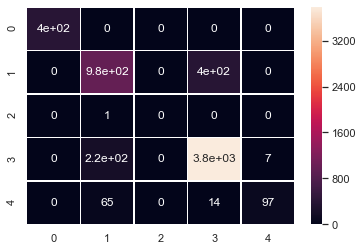

In [278]:
sns.set()
ax=sns.heatmap(cm_rf, annot=True, linewidths=.5)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [279]:
print(classification_report(y_test,y_predict_rf,target_names = ['Adulto ida', 'Flexible', 'Individual-Flexible', 'Promo',
       'Promo +']))

                     precision    recall  f1-score   support

         Adulto ida       1.00      1.00      1.00       403
           Flexible       0.78      0.71      0.74      1377
Individual-Flexible       0.00      0.00      0.00         1
              Promo       0.90      0.94      0.92      4010
            Promo +       0.93      0.55      0.69       176

           accuracy                           0.88      5967
          macro avg       0.72      0.64      0.67      5967
       weighted avg       0.88      0.88      0.88      5967



In [280]:
score_rf = round(accuracy_score(y_test, y_predict_rf, normalize=True),4)
print('Testing Accuracy Score for Random Forest is:', score_rf)

Testing Accuracy Score for Decision Tree is: 0.883


In [281]:
scores_rf = cross_val_score(grid_search_rf,X_train,y_train,scoring='accuracy',cv=5)
error_rf = [round(1-x,4) for x in scores_rf]

In [282]:
error_rf

[0.1261, 0.1326, 0.133, 0.1218, 0.1306]

In [283]:
prediction_errors = [error_svm, error_dt, error_rf]

[Text(0, 0, 'SVC'), Text(0, 0, 'Decision Tree'), Text(0, 0, 'Random Forest')]

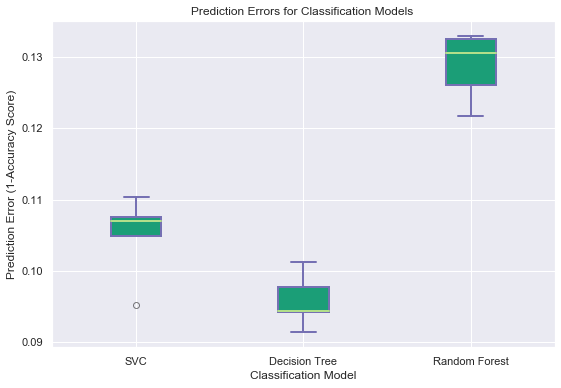

In [284]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(prediction_errors, patch_artist=True)

for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )
    
## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

plt.title('Prediction Errors for Classification Models ')
plt.ylabel('Prediction Error (1-Accuracy Score)')
plt.xlabel('Classification Model')
ax.set_xticklabels(['SVC', 'Decision Tree', 'Random Forest'])

## Selected Decision Tree

## Make a summary results table showing the accuracy score, confusion matrix, and classification report for the methods compared.

In [285]:
results = {'Models': ['Support Vector Classification', 'Decision Tree', 'Random Forest'],
          'Accuracy Scores': [score_svm, score_dt, score_rf]}

summary_results = pd.DataFrame(results)

summary_results

,Models,Accuracy Scores
0,Support Vector Classification,0.9006
1,Decision Tree,0.9075
2,Random Forest,0.8830


## Perform a sensitivity analysis on the effects of training % vs. testing %

In [286]:
size_list = []
accuracy_list = [] 

for size in np.linspace(0.1, 0.9, 9):
    size_list.append(size)
    split = StratifiedShuffleSplit(n_splits=1, test_size = size, random_state=42)
    for train_index, test_index in split.split(transp_df, transp_df['train_class']):
        strat_train_set = transp_df.loc[train_index]
        strat_test_set = transp_df.loc[test_index]
    X_train =  cat_encoder.fit_transform(strat_train_set.drop('fare', axis = 1))
    y_train = strat_train_set['fare'].copy()
    X_test =  cat_encoder.fit_transform(strat_test_set.drop('fare', axis = 1))
    y_test = strat_test_set['fare'].copy()
    grid_search_dt.fit(X_train, y_train)
    y_predict = grid_search_dt.predict(X_test)
    cm = confusion_matrix(y_test,y_predict)
    accuracy_list.append(round(accuracy_score(y_test, y_predict, normalize=True),4)) 
    
Sen_Analysis = pd.DataFrame()
Sen_Analysis['Test Size'] = size_list
Sen_Analysis['Accuracy'] = accuracy_list
Sen_Analysis

,Test Size,Accuracy
0,0.1,0.9129
1,0.2,0.9075
2,0.3,0.9066
3,0.4,0.9067
4,0.5,0.9058
5,0.6,0.9058
6,0.7,0.9049
7,0.8,0.9049
8,0.9,0.9039


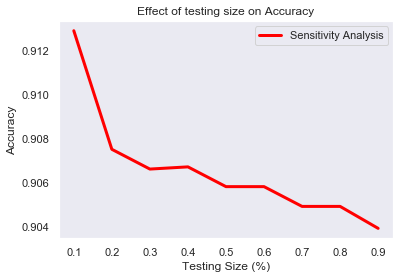

In [287]:
plt.plot(size_list, accuracy_list, color = 'red', label = 'Sensitivity Analysis', linewidth = 3)
plt.title('Effect of testing size on Accuracy')
plt.xlabel('Testing Size (%)')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

## Randomly create 10 instances based on the features used in the model, and then use the model to predict the fare paid.

In [288]:
random_instance = np.random.choice([0, 1], size=(10,55), p=[.5, .5])
random_predict = grid_search_dt.predict(random_instance)

In [289]:
le.inverse_transform(random_predict).reshape(-1,1)

array([['Adulto ida'],
       ['Promo'],
       ['Flexible'],
       ['Adulto ida'],
       ['Adulto ida'],
       ['Flexible'],
       ['Promo +'],
       ['Adulto ida'],
       ['Flexible'],
       ['Flexible']], dtype=object)

In [290]:
input_param = cat_encoder.inverse_transform(random_instance)

output = le.inverse_transform(random_predict).reshape(-1,1)

Data_Concat = np.concatenate((input_param,output),axis=1)

Random_results = pd.DataFrame(Data_Concat,columns = transp_df.columns)

Random_results

,origin,destination,train_type,price,train_class,travel_time(hrs),Week_Number,Month,fare
0,MADRID,MADRID,ALVIA,1,Preferente,1,16,4,Adulto ida
1,BARCELONA,MADRID,ALVIA,1,Cama G. Clase,3,16,4,Promo
2,MADRID,MADRID,AV City,1,Cama G. Clase,1,16,4,Flexible
3,PONFERRADA,SEVILLA,ALVIA,1,Cama Turista,1,16,4,Adulto ida
4,BARCELONA,SEVILLA,AV City,1,Cama Turista,1,22,5,Adulto ida
5,BARCELONA,BARCELONA,AV City,1,Cama G. Clase,2,16,4,Flexible
6,BARCELONA,MADRID,AV City,1,Cama Turista,4,16,4,Promo +
7,PONFERRADA,BARCELONA,ALVIA,1,Preferente,1,17,4,Adulto ida
8,BARCELONA,BARCELONA,ALVIA,3,Preferente,2,17,4,Flexible
9,BARCELONA,MADRID,ALVIA,1,Cama G. Clase,1,17,4,Flexible
